# *Проект Яндекс.Афиша. Анализ бизнес-показателей.*

# Цели работы:

1. Научиться работать с когортным анализом
2. Изучить, как люди пользуются продуктом
3. Изучить, когда люди начинают покупать
4. Изучить, сколько приносит каждый клиент
5. Изучить, когда клиент окупается

# Задачи работы:
## Продуктовые метрики:
1. Рассчитать DAU, WAU, MAU. Вычислить средние значения этих метрих за весь период.
2. Определить, сколько раз пользователи  заходят на сайт
3. Исследовать, сколько времени пользователи проводят проводят на сайте. Узнать продолжительность типичной пользовательской сессии
4. Рассчитать retention rate, применяя когортный анализ. Найти средний retention rate на второй месяц "жизни когорт"
## Метрики электронной коммерции:
1. Исследовать, сколько времени проходит с момента первого визита до момента первой покупки.
2. Применняя когортный анализ, узнать среднее количество покупок на одного покупателя за определённый период
3. Рассчитать средний чек
4. Выяснить, как меняется LTV по когортам. Рассчитать средний LTV за шесть месяцев.
## Маркетинговые метрики:
1. Посчитать общую сумму расходов на маркетинг. Выяснить, как траты распределены по источникам
2. Рассчитать средний CAC на одного покупателя и все источники
3. Рассчитать ROMI в разрезе всех источнков
## Сформулировать выводы и рекомендации:

# Описание данных:
##### Таблица visits (лог сервера с информацией о посещениях сайта):
1. Uid — уникальный идентификатор пользователя
2. Device — категория устройства пользователя
3. Start Ts — дата и время начала сессии
4. End Ts — дата и время окончания сессии
5. Source Id — идентификатор рекламного источника, из которого пришел пользователь
##### Таблица orders (информация о заказах):

1. Uid — уникальный id пользователя, который сделал заказ
2. Buy Ts — дата и время заказа
3. Revenue — выручка Яндекс.Афиши с этого заказа
##### Таблица costs (информация о затратах на маркетинг):

1. source_id — идентификатор рекламного источника
2. dt — дата
3. costs — затраты на этот рекламный источник в этот день

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Шаг 1. Загрузка и подготовка данных:

In [2]:
visit = pd.read_csv('/datasets/visits_log.csv')
order = pd.read_csv('/datasets/orders_log.csv')
cost = pd.read_csv('/datasets/costs.csv')

In [3]:
visit

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [4]:
visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Приведём названия столбцов к общепринятому виду

In [5]:
visit.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

Приведём столбцы start_ts и end_ts к типу datetime

In [6]:
visit['end_ts'] = pd.to_datetime(visit['end_ts'])
visit['start_ts'] = pd.to_datetime(visit['start_ts'])

In [7]:
visit

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


Проверим столбцы таблицы по времени посещения.

In [8]:
visit[visit['start_ts'] > visit['end_ts']]

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Видим две строки, в которых начало посещения позже, чем конец посещения. Так быть не может, поэтому думаю будет логично их удалить. Исчезновение двух строк особо не повлияет на результаты.

In [9]:
visit = visit.drop(visit[visit['start_ts'] > visit['end_ts']].index)

In [10]:
order

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [11]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Так же приведём названия столбцов к общепринятому виду

In [12]:
order.columns = ['buy_ts', 'revenue', 'uid']

buy_ts приведём к datetime

In [13]:
order['buy_ts'] = pd.to_datetime(order['buy_ts'])

In [14]:
order

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [15]:
cost

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [16]:
cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [17]:
cost['dt'] = pd.to_datetime(cost['dt'])

In [18]:
cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [19]:
visit[visit['start_ts'] > visit['end_ts']]

,device,end_ts,source_id,start_ts,uid


# Шаг 2. Построение отчётов и расчёт метрик

In [20]:
visit

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


 ### Рассчитаем DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период, а также построим график изменения метрик во времени;

Сколько людей пользуются продуктом в день, неделю и месяц?

Выясним день, неделю и месяц каждого визита

In [21]:
visit['day'] = visit['start_ts'].dt.date
visit['week'] = visit['start_ts'].dt.week
visit['month'] = visit['start_ts'].dt.month
visit['year'] = visit['start_ts'].dt.year
dau = visit.groupby('day').agg({'uid' : 'nunique'})
wau = visit.groupby(['year', 'week']).agg({'uid' : 'nunique'})
mau = visit.groupby(['year', 'month']).agg({'uid' : 'nunique'})

In [22]:
# Вычислим срееднее число визитов по этим метрикам
dau_total = dau.mean()
wau_total = wau.mean()
mau_total = mau.mean()

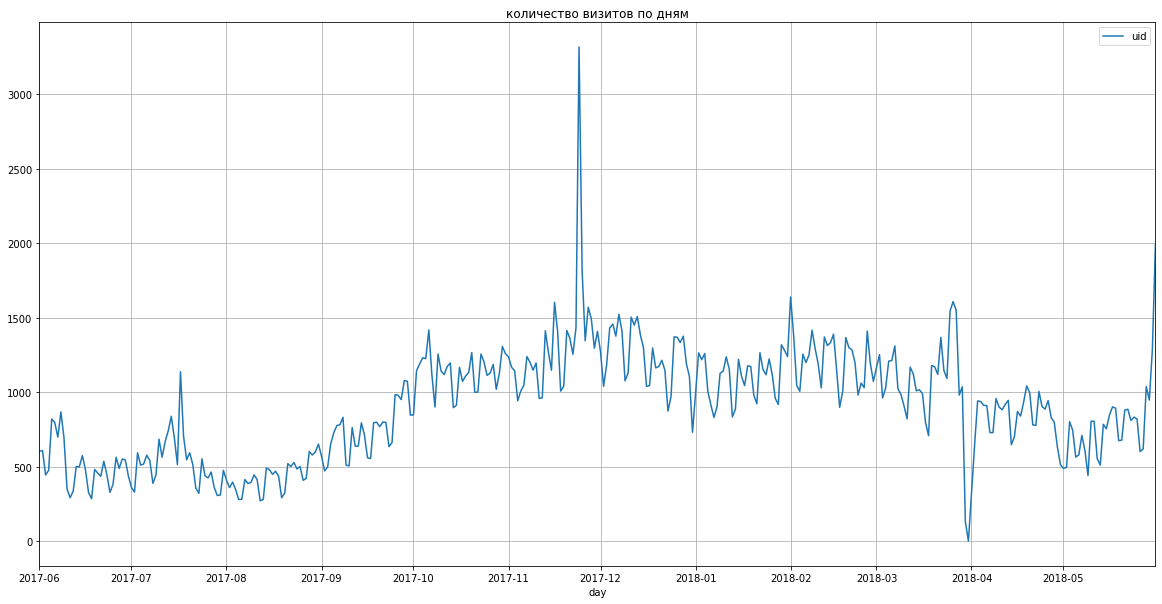

In [23]:
dau.plot(grid=True, figsize=(20, 10))
plt.title('количество визитов по дням')
plt.show()

##### Как мы видим, с июня 2017 по сентябрь 2017 количество визитов колеблется в районе 300 - 1000 визитов. В начале октября происходит рост и в среднем колеблется в районе 700 - 1500 визитов. В декабре видим резкий скачок визитов до 3000. Это можно объяснить подготовкой к новому году и покупкой билетов в качестве подарков. В начале апреля 2018 видим падение до нуля, что можно объяснить вохможным падением сайта или техническими работами. И далее в апреле и мае 2018 снижение визитов до позиций 500-1000 визитов в день. 

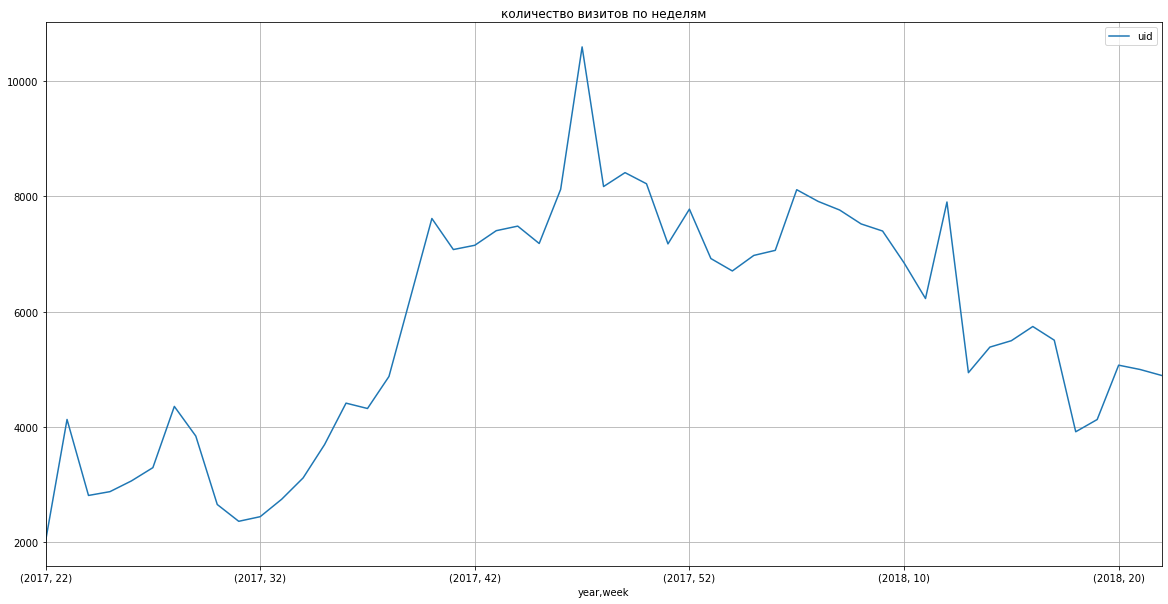

In [24]:
wau.plot(grid=True, figsize=(20, 10))
plt.title('количество визитов по неделям')
plt.show()

##### Колебания визитов за весь период происходят в промежутке от 2000 до 10000. С 22 недели по 37 неделю 2017 года количество визитов находится в промежутке между 2000 и 4200. Далее начинается рост и устанавливается стабильный рост-падение визитов, начиная с 40 недели 2017 по 11 неделю 2018 года, в промежутке 6000-8000 визитов. А в 46-47 недели виден скачок визитов до 10000.

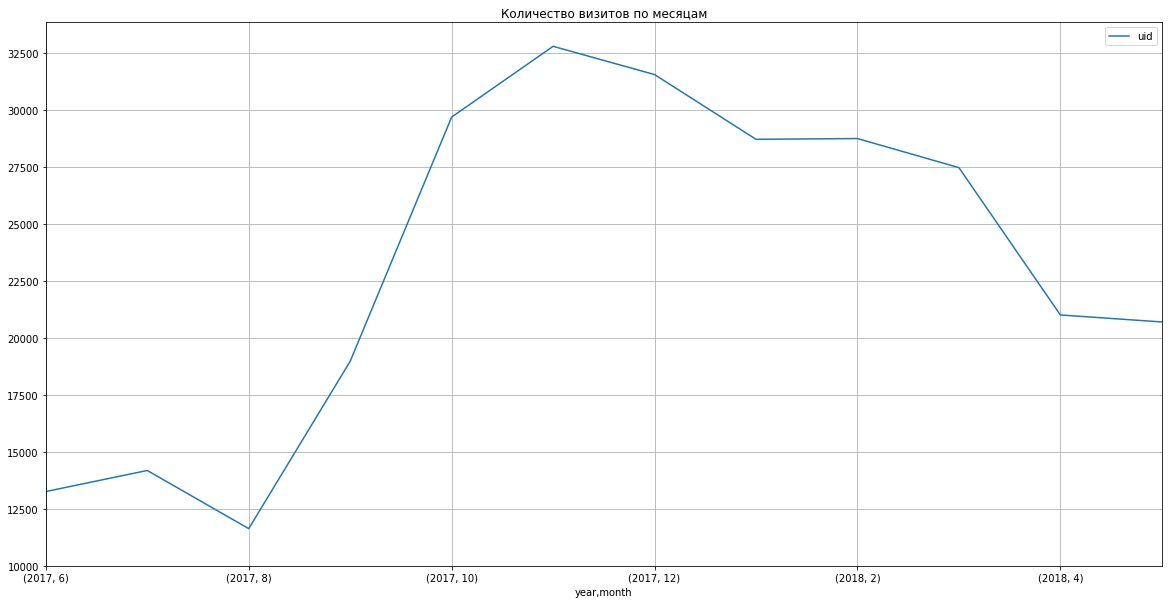

In [25]:
mau.plot(grid=True, figsize=(20, 10))
plt.yticks(np.arange(10000, 35000, step=2500))
plt.title('Количество визитов по месяцам')
plt.show()

##### Видим постепенный рост визитов, начиная с августа 2017 до декабря 2017. И постепенное падение после. Видимо, после лета люди планируют походы в разные места. Потому что если брать концерты и постановки, то, чтобы на них попасть, брать нужно заранее из-за возможной экономии и доступности билетов. Видимо, есть сезонность в активности пользователей. 

### Определим, сколько раз за день пользователи в среднем заходят на сайт. Выясним, как изменяется эта метрика с течением времени;

Вычислим количество заходов пользователей на сайт в день

In [26]:
visit

,device,end_ts,source_id,start_ts,uid,day,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,30,7,2017
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,4,1,2018
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,9,3,2018
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,44,11,2017


Вычислим количество сессий для каждого пользователя за день

In [27]:
session_per_user= visit.groupby('day').agg({'uid' : ['count', 'nunique']})
session_per_user.columns = ['n_session', 'n_user']
session_per_user['session_per_user'] = session_per_user['n_session'] / session_per_user['n_user']

In [28]:
session_per_user

,n_session,n_user,session_per_user
day,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


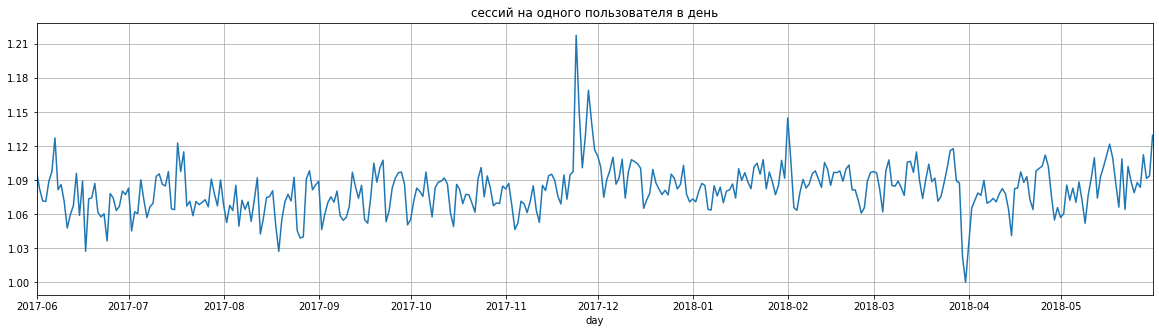

In [29]:
session_per_user['session_per_user'].plot(grid=True, figsize=(20, 5))
plt.yticks(np.arange(1, 1.24, step=0.03))
plt.title('сессий на одного пользователя в день')
plt.show()

##### Видим высокий пик посещений в декабре до 1,21 посещений в день и падение в апреле до 1 посещения. В июне-сентябре 2017 года колебания посещений варьируются в промежутке 1.03 - 1.13. Затем среднее количество посещений принимается достатоно стабильное значение в промежутке 1.05 - 1.1. После нового года с января 2018 среднее количество посещений становится достаточно высоким без резких падений в прмежутке 1.06 - 1.12 с резким пиков в феврале 2018 до 1.15. 

### Вычислим, сколько времени пользователи проводят на сайте. Узнаем, сколько длится типичная пользовательская сессия за весь период.

In [30]:
visit['session_duration'] = (visit['end_ts'] - visit['start_ts']).dt.seconds

In [31]:
print('Средняя продолжительность сессии за весь период равна: {}'.format(visit['session_duration'].mean()))

Средняя продолжительность сессии за весь период равна: 643.0422873805642


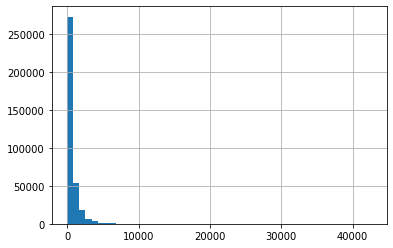

In [32]:
visit['session_duration'].hist(bins=50)

Распределение по времени визитов сильно скошено влево. Посмотрим на моду.

In [33]:
visit['session_duration'].mode()

0    60
dtype: int64

##### Среднее время визита - 60 секунд

### Рассчитаем retention rate визитов. Найдём средний retention rate на второй месяц

In [34]:
visit

,device,end_ts,source_id,start_ts,uid,day,week,month,year,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,30,7,2017,19
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,4,1,2018,19
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,9,3,2018,19
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,44,11,2017,19


In [35]:
first_visit = visit.groupby('uid')['start_ts'].min()
first_visit.name = 'first_visit'
visit = visit.merge(first_visit, on='uid')
visit['first_visit_month'] = visit['first_visit'].astype('datetime64[M]')
visit['visit_month'] = visit['start_ts'].astype('datetime64[M]')

In [36]:
visit['cohort_lifetime'] = visit['visit_month'] - visit['first_visit_month']
visit['cohort_lifetime'] = visit['cohort_lifetime'] / np.timedelta64(1, 'M')
visit['cohort_lifetime'] = visit['cohort_lifetime'].round().astype('int')

In [37]:
cohorts = visit.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid' : 'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] 

In [38]:
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum') 

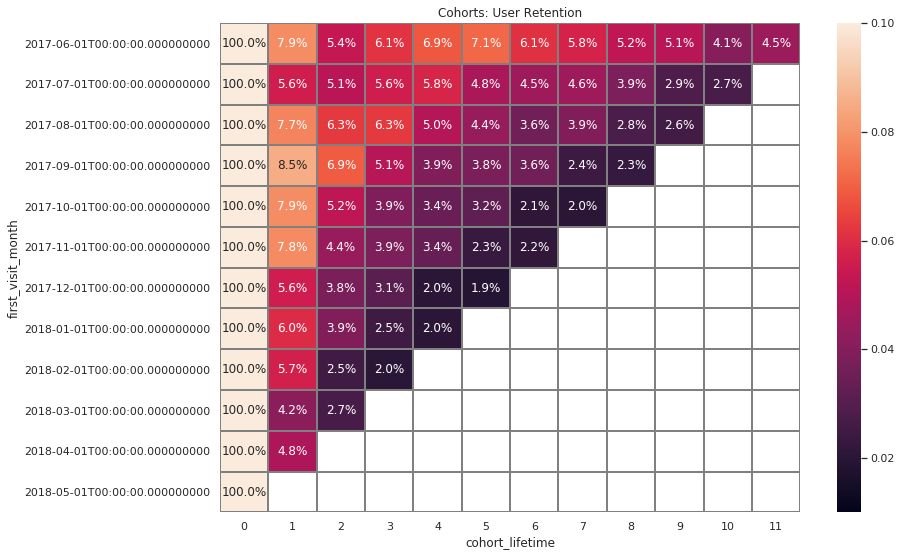

In [39]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0.01, vmax = 0.1)
plt.show()

##### Во всех когортах Retention rate резко падает на второй месяц использования до 5 - 8.5 процентов от первоначального количества пользователей. Более высокими показателями обладают когорты следующих месяцев: июнь, август, сентябрь, октябрь, ноябрь 2017 года.

In [40]:
print('Cредний retention rate на второй месяц "жизни" когорт: {}'.format(cohorts[cohorts['cohort_lifetime']==1]['retention'].mean()))

Cредний retention rate на второй месяц "жизни" когорт: 0.06516659710392834


# Шаг 2. Метрики электронной коммерции

### Сколько времени проходит до покупки с первого посещения сайта. 

Нужно сгруппировать таблицы visit и order по покупателям и найти минимальное время посещения и покупок. А далее найти разницу

In [41]:
visit

,device,end_ts,source_id,start_ts,uid,day,week,month,year,session_duration,first_visit,first_visit_month,visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359393,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23,17,4,2018,480,2018-04-23 21:11:00,2018-04-01,2018-04-01,0
359394,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-08,45,11,2017,0,2017-11-08 13:39:00,2017-11-01,2017-11-01,0
359395,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017-07-31,31,7,2017,1080,2017-07-31 12:13:00,2017-07-01,2017-07-01,0
359396,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018-03-20,12,3,2018,840,2018-03-20 15:11:00,2018-03-01,2018-03-01,0


In [42]:
first_session = visit.groupby('uid')['start_ts'].min().reset_index()
first_session.columns = ['uid', 'first_session']

In [43]:
order

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [44]:
first_purchase = order.groupby('uid')['buy_ts'].min().reset_index()
first_purchase.columns = ['uid', 'first_purchase']

In [45]:
mean_purchase_time = first_session.merge(first_purchase, on='uid')

In [46]:
mean_purchase_time

,uid,first_session,first_purchase
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00


Найдём время до покупки

In [47]:
mean_purchase_time['time_till_purchase'] = (mean_purchase_time['first_purchase'] - 
                                            mean_purchase_time['first_session'])/np.timedelta64(1, 'm')
mean_purchase_time['time_till_purchase'] = mean_purchase_time['time_till_purchase'].round(1)

Посмотрим на распределение времени до первой покупки.

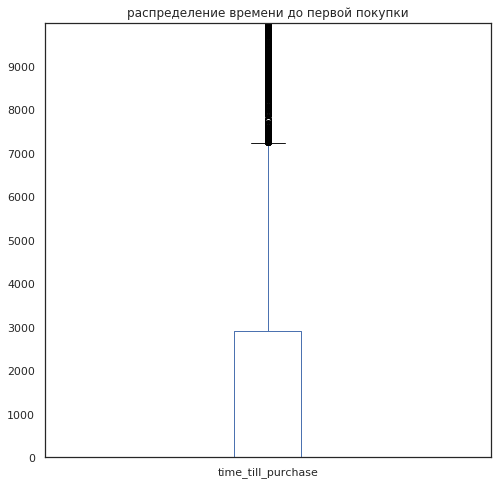

In [48]:
mean_purchase_time['time_till_purchase'].plot(kind='box', 
                                        figsize=(8, 8), title='распределение времени до первой покупки', ylim=(0, 10000))
plt.yticks(np.arange(0, 10000, step=1000))
plt.show()

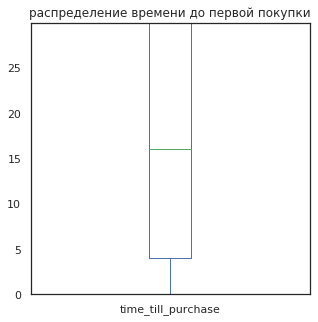

In [49]:
mean_purchase_time['time_till_purchase'].plot(kind='box', 
                                        figsize=(5, 5), title='распределение времени до первой покупки', ylim=(0, 30))
plt.yticks(np.arange(0, 30, step=5))
plt.show()

In [50]:
mean_purchase_time['time_till_purchase'].median()

16.0

##### Большинство значений укладываются в промежуток от 4 минут до 3000 минут (5 часов). Выбросы начинаются с 7000 минут. Медиана же находится на уровне 16 минут.

### Применяя когортный анализ, рассчитайте среднее количество покупок на одного клиента за определённый период, например за 6 месяцев;

In [51]:
order

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


Получим первый месяц покупки и месяц покупки для каждого покупателя

In [52]:
first_order = order.groupby('uid')['buy_ts'].min()
first_order.name = 'first_order'
order = order.merge(first_order, on='uid')
order['first_order_month'] = order['first_order'].astype('datetime64[M]')
order['order_month'] = order['buy_ts'].astype('datetime64[M]')

In [53]:
order

,buy_ts,revenue,uid,first_order,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01


In [54]:
order['cohort_lifetime'] = order['order_month'] - order['first_order_month']
order['cohort_lifetime'] = order['cohort_lifetime']/np.timedelta64(1, 'M')
order['cohort_lifetime'] = order['cohort_lifetime'].round().astype('int')

In [55]:
order_cohorts = order.groupby(['first_order_month', 'cohort_lifetime']).agg({'uid' : 'nunique', 'buy_ts' : 'count'}).reset_index()

In [56]:
order_cohorts = order_cohorts.rename(columns={'uid' : 'uid_sum', 'buy_ts' : 'bought_products'})

In [57]:
order_cohorts

,first_order_month,cohort_lifetime,uid_sum,bought_products
0,2017-06-01,0,2023,2354
1,2017-06-01,1,61,177
2,2017-06-01,2,50,174
3,2017-06-01,3,54,226
4,2017-06-01,4,88,292
...,...,...,...,...
74,2018-03-01,2,58,176
75,2018-04-01,0,2276,2495
76,2018-04-01,1,69,195
77,2018-05-01,0,2988,3249


In [58]:
order_cohorts['products_per_id'] = (order_cohorts['bought_products'] / order_cohorts['uid_sum']).round(1)

In [59]:
products_per_id_pivot = order_cohorts.pivot_table(index='first_order_month', columns='cohort_lifetime', values='products_per_id')

In [60]:
products_per_id_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.2,2.9,3.5,4.2,3.3,3.3,4.5,3.7,3.7,3.4,2.1,1.6
2017-07-01,1.1,1.9,2.1,1.6,1.5,2.2,1.7,1.3,1.4,1.1,2.0,NaN
2017-08-01,1.1,1.9,1.9,1.8,2.1,1.9,1.6,1.8,2.4,1.5,NaN,NaN
2017-09-01,1.1,1.7,1.6,2.2,1.3,1.7,1.6,1.5,1.4,NaN,NaN,NaN
2017-10-01,1.1,1.5,1.3,1.3,1.4,1.4,1.5,1.9,NaN,NaN,NaN,NaN
2017-11-01,1.2,1.8,1.5,2.0,1.7,1.2,1.6,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.2,1.8,2.0,1.8,1.7,1.7,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.1,2.0,1.9,1.5,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.1,1.9,1.4,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


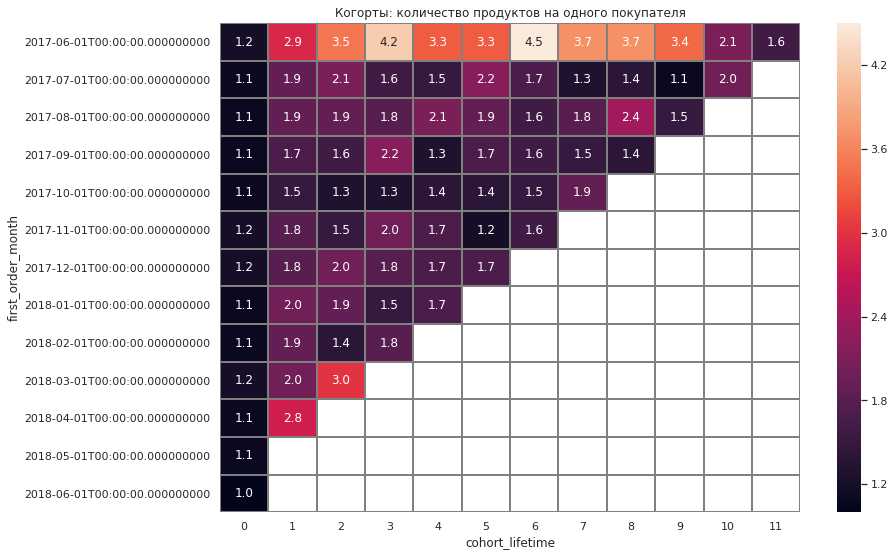

In [61]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: количество продуктов на одного покупателя')
sns.heatmap(products_per_id_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

##### Видим изменение количества продуктов на одного покупателя в большинстве когорт в промежутке 1.5 - 2.0. Выбивается только первая когорта с пиковыми значениями в сентябре (4.2) и декабре (4.5). Также можно заметить тренд повышения покупок в декабре в первым четырёх когортах, что может быть связано с покупкой подарков. Самой лояльной остаётся первая когорта.

Посмотрим на среднее количество покупок на одного покупателя за шесть месяцев.

In [62]:
products_per_id_pivot.cumsum(axis=1).mean()[5]

10.957142857142857

##### Среднее количество покупок за 6 месяцев на одного покупателя около 11 

### Найдём средний чек одной покупки

In [63]:
order

,buy_ts,revenue,uid,first_order,first_order_month,order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0


Чтобы найти средний чек, создаём когорты по суммарной прибыли и количеству покупок

In [64]:
revenue_cohorts = order.groupby(['first_order_month', 'cohort_lifetime']).agg({'revenue' : 'sum', 'uid' : 'count'})

In [65]:
revenue_cohorts['check'] = (revenue_cohorts['revenue'] / revenue_cohorts['uid']).round(1)

In [66]:
check_pivot = revenue_cohorts.pivot_table(index='first_order_month', columns='cohort_lifetime', values='check', aggfunc='mean')

In [67]:
check_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.1,5.5,5.1,8.5,7.1,6.8,7.0,6.8,5.3,8.0,12.0,6.0
2017-07-01,5.3,6.4,10.0,6.6,4.7,3.7,3.8,5.5,5.3,11.8,5.6,NaN
2017-08-01,4.7,6.0,6.3,6.6,8.0,6.3,5.9,7.1,8.7,5.6,NaN,NaN
2017-09-01,5.0,13.2,8.4,62.6,15.4,15.3,16.8,11.2,7.8,NaN,NaN,NaN
2017-10-01,4.4,7.4,5.1,5.6,5.1,5.1,4.3,4.0,NaN,NaN,NaN,NaN
2017-11-01,4.4,4.1,4.5,6.3,4.4,3.7,4.6,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.1,4.2,20.1,26.1,15.9,14.1,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.7,4.4,6.5,7.5,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.7,4.6,3.5,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


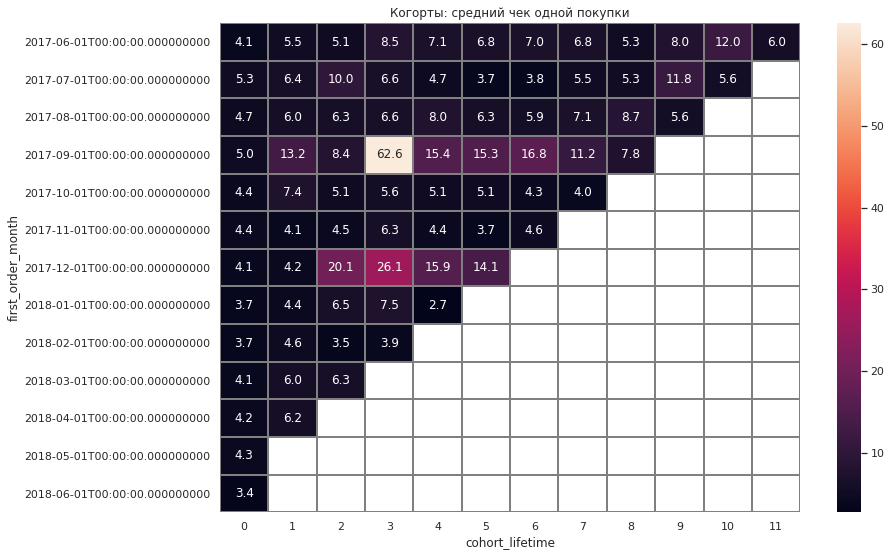

In [68]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: средний чек одной покупки')
sns.heatmap(check_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

##### У всех когорт на первом месяце жизни средний чек не превышает 4 - 5. У большиства когорт средний чек на всём времени жизни находится в пределах 4 - 8. Но у сетрябрьской и декабрьской когорт значения выгодно отличаются. Сентрябрьская когорта имееют чек в промежутке 8 - 17, а в декабре и вовсе имеет пиковое значение в 63. Декабрьская когорта, начиная с 3 месяца жизни, имеет высокий средний чек в промежутке 14 - 26.

### Найдём LTV на покупателя по когортам. А также рассчитаем LTV за 6 месяцев

Далее, чтобы найти LTV, вычислим среднюю выручку с пользователя. Создадим когорты по уникальным пользователям и суммарной прибыли за каждый месяц. Маржинальность 100 процентов, поэтому останется вычислить только накопительную сумму по месяцам.

In [69]:
order

,buy_ts,revenue,uid,first_order,first_order_month,order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0


In [70]:
cohort_order_sizes = order.groupby('first_order_month').agg({'uid' : 'nunique'}).reset_index()

In [71]:
cohort_order_sizes

,first_order_month,uid
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [72]:
revenue_order_cohorts = (order.groupby(['first_order_month', 'cohort_lifetime']).agg({'revenue' : 'sum'})).reset_index()

In [73]:
ltv_cohorts = revenue_order_cohorts.merge(cohort_order_sizes, on = 'first_order_month', how = 'left')

In [74]:
ltv_cohorts['revenue_per_user'] = (ltv_cohorts['revenue'] / ltv_cohorts['uid']).round(1)

Построим сводную таблицу и тепловую карту по этим данным

In [75]:
ltv_pivot = ltv_cohorts.pivot_table(index='first_order_month', columns='cohort_lifetime', values='revenue_per_user', 
                                    aggfunc='mean').cumsum(axis=1)

In [76]:
ltv_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.7,5.2,5.6,6.6,7.6,8.3,9.3,9.9,10.5,11.1,11.7,12.0
2017-07-01,6.0,6.3,6.9,7.3,7.5,7.7,7.8,7.9,8.1,8.2,8.4,NaN
2017-08-01,5.3,5.8,6.3,6.7,7.2,7.5,7.7,8.1,8.4,8.6,NaN,NaN
2017-09-01,5.6,6.7,7.2,11.2,11.6,12.2,12.9,13.1,13.3,NaN,NaN,NaN
2017-10-01,5.0,5.5,5.7,5.9,6.1,6.2,6.3,6.4,NaN,NaN,NaN,NaN
2017-11-01,5.2,5.6,5.8,6.1,6.2,6.3,6.4,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.7,5.0,5.9,7.0,7.3,7.6,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.1,4.4,4.7,4.8,4.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.2,4.5,4.6,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


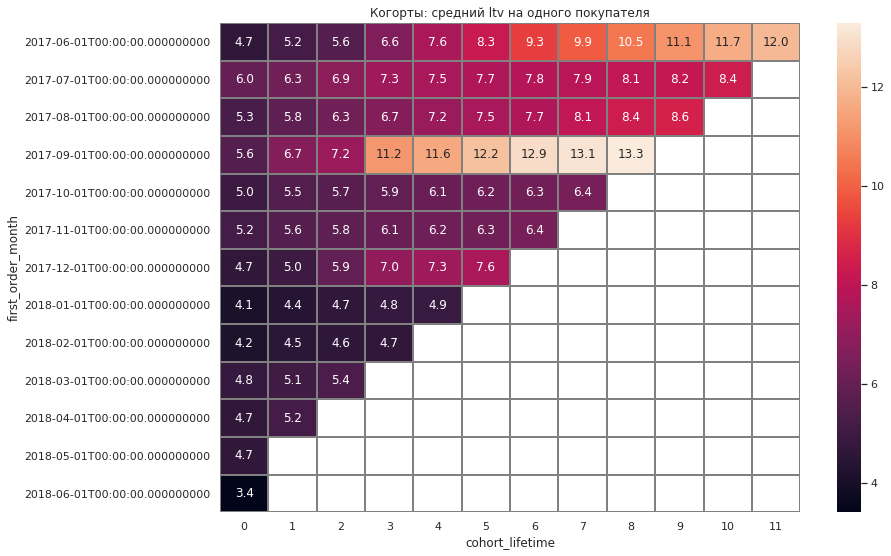

In [77]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: средний ltv на одного покупателя')
sns.heatmap(ltv_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

##### Выделяются три когорты: июньская, сентябрьская и декабрьская. Июньская имеет достаточно линейный рост ltv, поэтому можно ожидать от этой когорты активности и в дальнейшем. Сентябрьская когорта резко возрастает в декабре по рассматриваемому параметру с 7 до 11 и к седьмому месяцу имеет ltv,  сравнимый с первой когортой на 12 месяц. Июльская, августовская и декабрьская когорты растут быстрее, чем оставшиеся.  Декабрьская имеет ltv на шестой месяц выше, чем первая когорта.

In [78]:
order

,buy_ts,revenue,uid,first_order,first_order_month,order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0


### Рассчитаем средний LTV по когортам за 6 месяцев; в расчёте оставим когорты «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%.

In [79]:
print('Средний Ltv за 6 месяцев равен: {}'.format(ltv_pivot.mean()[5]))

Средний Ltv за 6 месяцев равен: 7.971428571428572


# Маркетинговые метрики

### Рассчитаем сумму расходов на маркетинг и отобразим расходы по источникам

In [80]:
cost

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [81]:
print('Общие затраты на маркетинг: {}'.format(cost['costs'].sum()))

Общие затраты на маркетинг: 329131.62


In [82]:
source_cost = cost.groupby('source_id').agg({'costs' : 'sum'}).sort_values(by='costs')

In [83]:
source_cost

,costs
source_id,
9,5517.49
10,5822.49
1,20833.27
2,42806.04
5,51757.10
4,61073.60
3,141321.63


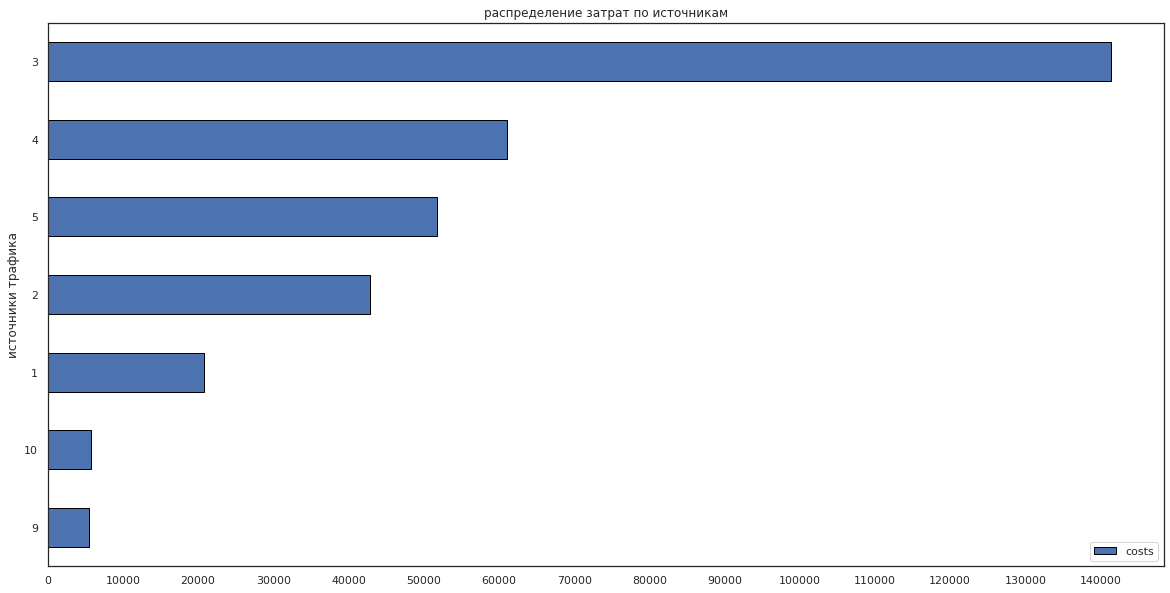

In [84]:
source_cost.plot(kind='barh', figsize=(20, 10), ec='black', title='распределение затрат по источникам')
plt.ylabel('источники трафика')
plt.xticks(np.arange(0, 145000, step=10000))
plt.show()

##### Источник три имеет наибольшую стоимость привлечения  и составляет чуть меньше половины от всех затрат. За ним идут с небольшой разницей источники 4, 5 и 2 соответственно. На последнем месте по затратам находится источник номер 9

### Рассчитаем стоимость привлечения одного клиента для всего проекта и по каждому источнику

In [85]:
order

,buy_ts,revenue,uid,first_order,first_order_month,order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0


In [86]:
cost = cost.rename(columns={'dt' : 'date'})

In [87]:
cost

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [88]:
visit

,device,end_ts,source_id,start_ts,uid,day,week,month,year,session_duration,first_visit,first_visit_month,visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359393,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23,17,4,2018,480,2018-04-23 21:11:00,2018-04-01,2018-04-01,0
359394,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-08,45,11,2017,0,2017-11-08 13:39:00,2017-11-01,2017-11-01,0
359395,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017-07-31,31,7,2017,1080,2017-07-31 12:13:00,2017-07-01,2017-07-01,0
359396,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018-03-20,12,3,2018,840,2018-03-20 15:11:00,2018-03-01,2018-03-01,0


Получим первый источник привлечения пользователя из таблицы визитов

In [89]:
visit_source = visit.sort_values('start_ts').groupby('uid')['source_id'].first().reset_index()

In [90]:
visit_source

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
...,...,...
228164,18446403737806311543,5
228165,18446424184725333426,4
228166,18446556406699109058,3
228167,18446621818809592527,4


In [91]:
order_source = order.merge(visit_source, on='uid', how='left')

In [92]:
order_source

,buy_ts,revenue,uid,first_order,first_order_month,order_month,cohort_lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0,3


Выделим уникальных покупателей по дате покупки и источникам.

In [93]:
order_source['date'] = order_source['first_order'].astype('datetime64[D]')

In [94]:
order_source_grouped = order_source.groupby(['date', 'source_id']).agg({'uid' : 'nunique'}).reset_index()

In [95]:
order_source_grouped = order_source_grouped.rename(columns={'uid' : 'n_buyers'})

In [96]:
order_source_grouped

,date,source_id,n_buyers
0,2017-06-01,1,14
1,2017-06-01,2,11
2,2017-06-01,3,33
3,2017-06-01,4,10
4,2017-06-01,5,13
...,...,...,...
2430,2018-05-31,4,82
2431,2018-05-31,5,37
2432,2018-05-31,9,5
2433,2018-05-31,10,35


In [97]:
cost

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


Теперь можем соединить таблицы по дате и источнику

In [98]:
cost_source = cost.merge(order_source_grouped, on=['date', 'source_id'], how='left')

In [99]:
cost_source

,source_id,date,costs,n_buyers
0,1,2017-06-01,75.20,14.0
1,1,2017-06-02,62.25,7.0
2,1,2017-06-03,36.53,7.0
3,1,2017-06-04,55.00,3.0
4,1,2017-06-05,57.08,18.0
...,...,...,...,...
2537,10,2018-05-27,9.92,2.0
2538,10,2018-05-28,21.26,10.0
2539,10,2018-05-29,11.32,7.0
2540,10,2018-05-30,33.15,5.0


Теперь вычислим cac

In [100]:
cost_source['cac'] = cost_source['costs'] / cost_source['n_buyers']

In [101]:
cost_source

,source_id,date,costs,n_buyers,cac
0,1,2017-06-01,75.20,14.0,5.371429
1,1,2017-06-02,62.25,7.0,8.892857
2,1,2017-06-03,36.53,7.0,5.218571
3,1,2017-06-04,55.00,3.0,18.333333
4,1,2017-06-05,57.08,18.0,3.171111
...,...,...,...,...,...
2537,10,2018-05-27,9.92,2.0,4.960000
2538,10,2018-05-28,21.26,10.0,2.126000
2539,10,2018-05-29,11.32,7.0,1.617143
2540,10,2018-05-30,33.15,5.0,6.630000


Выделим первый месяц расходов и построим график cac для каждого источника трафика

In [102]:
cost_source['month'] = cost_source['date'].astype('datetime64[M]')

In [103]:
cost_source

,source_id,date,costs,n_buyers,cac,month
0,1,2017-06-01,75.20,14.0,5.371429,2017-06-01
1,1,2017-06-02,62.25,7.0,8.892857,2017-06-01
2,1,2017-06-03,36.53,7.0,5.218571,2017-06-01
3,1,2017-06-04,55.00,3.0,18.333333,2017-06-01
4,1,2017-06-05,57.08,18.0,3.171111,2017-06-01
...,...,...,...,...,...,...
2537,10,2018-05-27,9.92,2.0,4.960000,2018-05-01
2538,10,2018-05-28,21.26,10.0,2.126000,2018-05-01
2539,10,2018-05-29,11.32,7.0,1.617143,2018-05-01
2540,10,2018-05-30,33.15,5.0,6.630000,2018-05-01


In [104]:
cac_pivot = cost_source.pivot_table(index='month', columns='source_id', values='cac', aggfunc = 'mean')

In [105]:
cac_pivot

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,11.681283,12.883568,16.716919,10.792094,9.209676,5.253654,4.590158
2017-07-01,9.491485,18.000253,18.593952,8.054482,7.938157,5.582433,6.151880
2017-08-01,12.118898,18.886449,19.795068,11.554926,6.879620,4.900254,5.813398
2017-09-01,8.155731,17.672249,13.084043,9.533800,6.864844,6.049126,8.306581
2017-10-01,8.202083,14.193003,14.613088,6.233562,6.305969,5.923235,6.362921
2017-11-01,8.908503,17.437690,16.091445,5.013132,9.368019,9.400503,10.801337
2017-12-01,8.570439,13.871086,12.948321,5.656507,8.399174,7.899420,7.803197
2018-01-01,11.719181,15.850151,15.134989,5.901092,9.371755,9.792713,9.851557
2018-02-01,10.752216,18.209325,13.894612,5.428068,7.725369,8.181382,4.489624


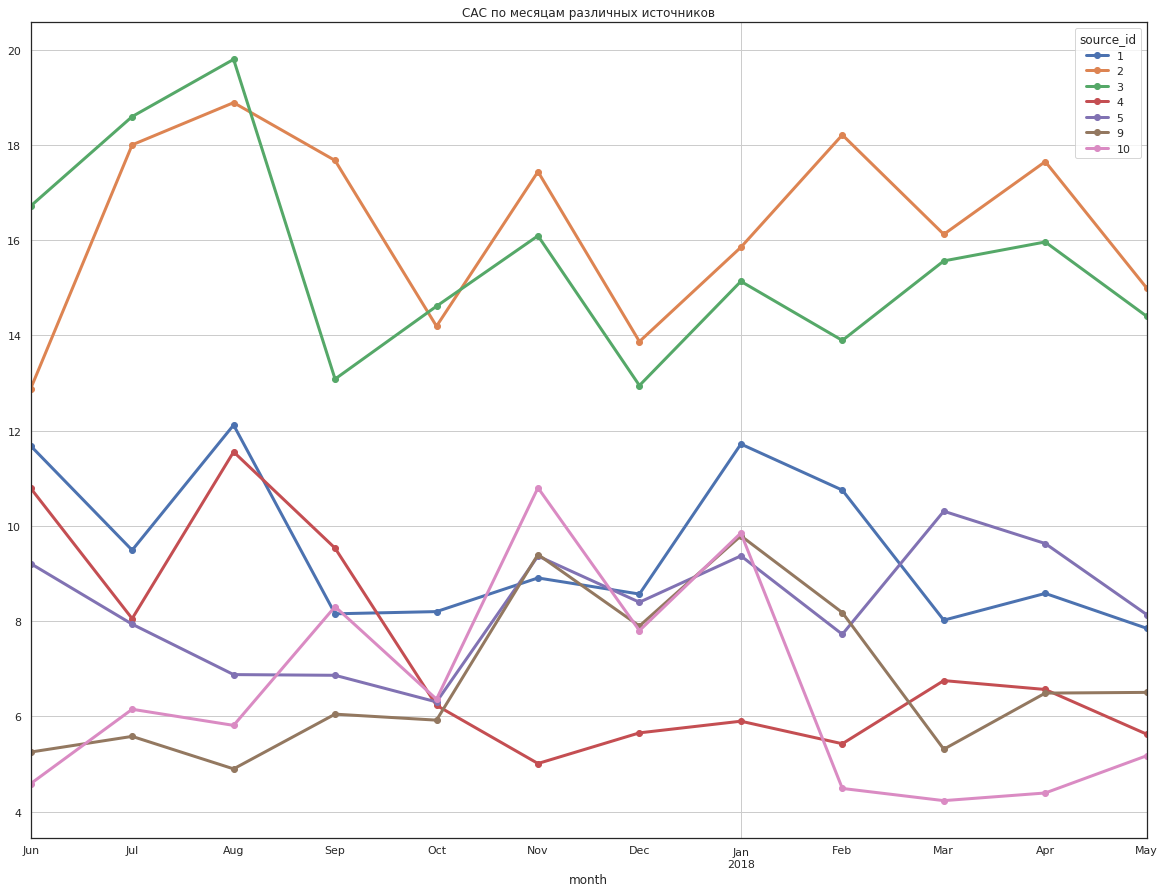

In [106]:
cac_pivot.plot(style='o-', grid=True, figsize=(20, 15), linewidth=3, 
               title='CAC по месяцам различных источников')
plt.show()

##### Самыми дорогими оказались источники 2 и 3. Источник три колеблется в промежутке 13 -20, а источник 2  - в промежутке 13 - 19. Можем отметить рост стоимости привлечения  в определённые месяцы для большиснтва когорт: источники 1-4 растут в цене с июня по август, в ноябре подешевел только источник 4, а остальные подорожали, в январе видим рост стоимости всех источников. В сентябре и декабре видим снижение стоимости почти всех платформ. Можем предположить, что в эти месяцы реклама не так важна и покупатели сами стремятся за билетами на ресурс, чтобы заполучить подарок для себя или других. В точках повышения стоимости возможно снижение проактивности покупателей.

### Рассчитаем ROMI  в разрезе источников

In [107]:
ltv_cohorts

,first_order_month,cohort_lifetime,revenue,uid,revenue_per_user
0,2017-06-01,0,9557.49,2023,4.7
1,2017-06-01,1,981.82,2023,0.5
2,2017-06-01,2,885.34,2023,0.4
3,2017-06-01,3,1931.30,2023,1.0
4,2017-06-01,4,2068.58,2023,1.0
...,...,...,...,...,...
74,2018-03-01,2,1114.87,3533,0.3
75,2018-04-01,0,10600.69,2276,4.7
76,2018-04-01,1,1209.92,2276,0.5
77,2018-05-01,0,13925.76,2988,4.7


Чтобы посчитать ROMI по источникам нам нужен cac по источникам и ltv по источникам. Второе поделим на первое

In [108]:
cost_source

,source_id,date,costs,n_buyers,cac,month
0,1,2017-06-01,75.20,14.0,5.371429,2017-06-01
1,1,2017-06-02,62.25,7.0,8.892857,2017-06-01
2,1,2017-06-03,36.53,7.0,5.218571,2017-06-01
3,1,2017-06-04,55.00,3.0,18.333333,2017-06-01
4,1,2017-06-05,57.08,18.0,3.171111,2017-06-01
...,...,...,...,...,...,...
2537,10,2018-05-27,9.92,2.0,4.960000,2018-05-01
2538,10,2018-05-28,21.26,10.0,2.126000,2018-05-01
2539,10,2018-05-29,11.32,7.0,1.617143,2018-05-01
2540,10,2018-05-30,33.15,5.0,6.630000,2018-05-01


In [109]:
cac_source = (cost_source.groupby('source_id')['cac'].mean()).reset_index()
cac_source

,source_id,cac
0,1,9.489732
1,2,16.287024
2,3,15.580474
3,4,7.271743
4,5,8.336731
5,9,6.842532
6,10,6.555415


Теперь расчитаем ltv по источникам

In [110]:
order_source

,buy_ts,revenue,uid,first_order,first_order_month,order_month,cohort_lifetime,source_id,date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3,2017-06-01
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,4,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,10,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0,3,2018-05-31
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0,3,2018-05-31


In [111]:
revenue_source = order_source.groupby(['source_id', 'first_order_month', 'cohort_lifetime'])['revenue'].sum().reset_index()
revenue_source

,source_id,first_order_month,cohort_lifetime,revenue
0,1,2017-06-01,0,1378.70
1,1,2017-06-01,1,414.98
2,1,2017-06-01,2,419.43
3,1,2017-06-01,3,714.24
4,1,2017-06-01,4,811.20
...,...,...,...,...
511,10,2018-03-01,0,638.44
512,10,2018-03-01,1,12.71
513,10,2018-03-01,2,6.29
514,10,2018-04-01,0,261.93


In [112]:
source_n_buyers = order_source.groupby(['source_id', 'first_order_month']).agg({'uid' : 'nunique'}).reset_index()

Теперь соединим таблицы и рассчитаем ltv

In [113]:
ltv_source = revenue_source.merge(source_n_buyers, on=['source_id', 'first_order_month'])
ltv_source

,source_id,first_order_month,cohort_lifetime,revenue,uid
0,1,2017-06-01,0,1378.70,190
1,1,2017-06-01,1,414.98,190
2,1,2017-06-01,2,419.43,190
3,1,2017-06-01,3,714.24,190
4,1,2017-06-01,4,811.20,190
...,...,...,...,...,...
511,10,2018-03-01,0,638.44,186
512,10,2018-03-01,1,12.71,186
513,10,2018-03-01,2,6.29,186
514,10,2018-04-01,0,261.93,107


In [114]:
ltv_source['ltv'] = ltv_source['revenue'] / ltv_source['uid']

In [115]:
ltv_source = ltv_source.rename(columns = {'uid' : 'n_buyers'})

In [116]:
ltv_source

,source_id,first_order_month,cohort_lifetime,revenue,n_buyers,ltv
0,1,2017-06-01,0,1378.70,190,7.256316
1,1,2017-06-01,1,414.98,190,2.184105
2,1,2017-06-01,2,419.43,190,2.207526
3,1,2017-06-01,3,714.24,190,3.759158
4,1,2017-06-01,4,811.20,190,4.269474
...,...,...,...,...,...,...
511,10,2018-03-01,0,638.44,186,3.432473
512,10,2018-03-01,1,12.71,186,0.068333
513,10,2018-03-01,2,6.29,186,0.033817
514,10,2018-04-01,0,261.93,107,2.447944


Соединим таблицу cac  с ltv_source

In [117]:
ltv_cac = ltv_source.merge(cac_source, on='source_id', how='left')
ltv_cac['romi'] = ltv_cac['ltv'] / ltv_cac['cac']
ltv_cac

,source_id,first_order_month,cohort_lifetime,revenue,n_buyers,ltv,cac,romi
0,1,2017-06-01,0,1378.70,190,7.256316,9.489732,0.764649
1,1,2017-06-01,1,414.98,190,2.184105,9.489732,0.230155
2,1,2017-06-01,2,419.43,190,2.207526,9.489732,0.232623
3,1,2017-06-01,3,714.24,190,3.759158,9.489732,0.396129
4,1,2017-06-01,4,811.20,190,4.269474,9.489732,0.449905
...,...,...,...,...,...,...,...,...
511,10,2018-03-01,0,638.44,186,3.432473,6.555415,0.523609
512,10,2018-03-01,1,12.71,186,0.068333,6.555415,0.010424
513,10,2018-03-01,2,6.29,186,0.033817,6.555415,0.005159
514,10,2018-04-01,0,261.93,107,2.447944,6.555415,0.373423


In [118]:
ltv_cac['first_order_month'] = ltv_cac['first_order_month'].astype('str')

In [119]:
ltv_cac

,source_id,first_order_month,cohort_lifetime,revenue,n_buyers,ltv,cac,romi
0,1,2017-06-01,0,1378.70,190,7.256316,9.489732,0.764649
1,1,2017-06-01,1,414.98,190,2.184105,9.489732,0.230155
2,1,2017-06-01,2,419.43,190,2.207526,9.489732,0.232623
3,1,2017-06-01,3,714.24,190,3.759158,9.489732,0.396129
4,1,2017-06-01,4,811.20,190,4.269474,9.489732,0.449905
...,...,...,...,...,...,...,...,...
511,10,2018-03-01,0,638.44,186,3.432473,6.555415,0.523609
512,10,2018-03-01,1,12.71,186,0.068333,6.555415,0.010424
513,10,2018-03-01,2,6.29,186,0.033817,6.555415,0.005159
514,10,2018-04-01,0,261.93,107,2.447944,6.555415,0.373423


Создадим функцию для построения тепловых карт когортного анализа по разным источникам. 

In [120]:
def romi_source_cohorts(i):
    romi_pivot = ltv_cac.loc[ltv_cac['source_id'] == i].pivot_table(index='first_order_month', columns='cohort_lifetime', 
                                                              values='romi', aggfunc='mean').cumsum(axis=1)
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Когорты: средний romi источника {}'.format(i))
    sns.heatmap(romi_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black', cbar_kws = {'orientation' : 'horizontal'})
    plt.show()

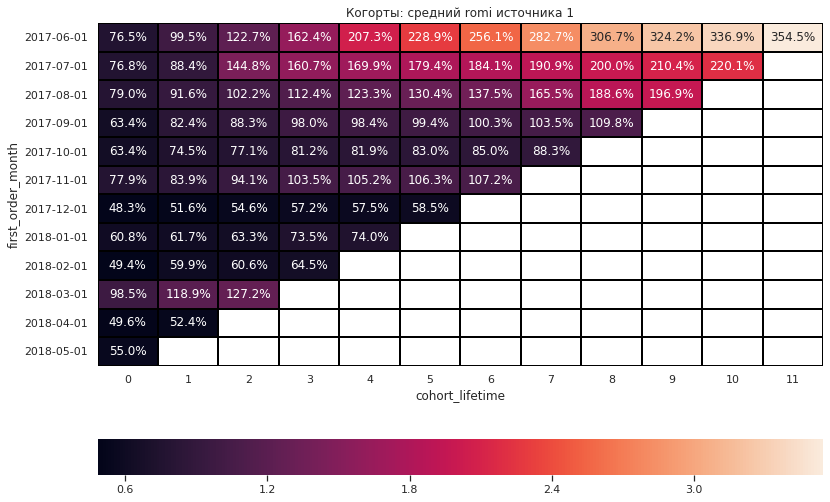

In [121]:
romi_source_cohorts(1)

Июньская, июльская и августовская когорты окупились уже на третий месяц. Сентябрьская когорта окупилась на седьмой месяц. Ноябрьская - на четвёртый. А мартовская когорта 2018 года окупилась на второй месяц. То есть половина когорт по данному источнику уже окупились. А четыре когорты уже приносят прибыль.


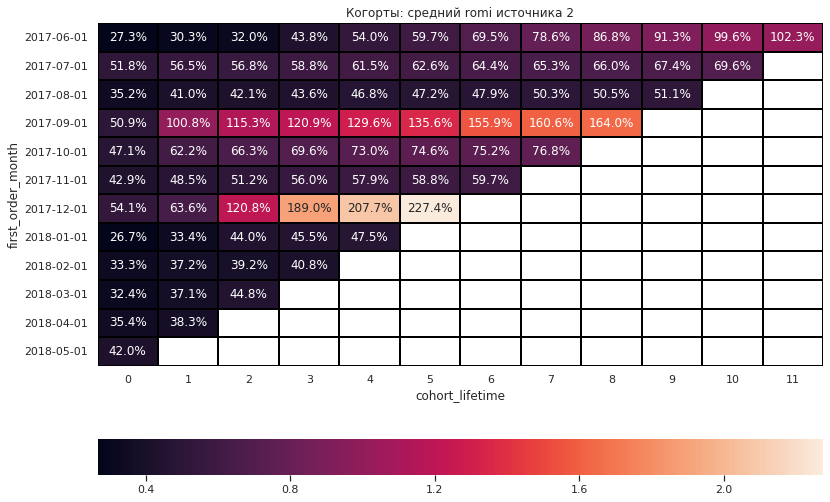

In [122]:
romi_source_cohorts(2)

В данном блоке окупились три когорты. Первая на  - 12й месяц. Сентябрьская - на второй и декабрьская - на 3 месяц. Этот источник выглядит уже менее выгодным, чем первый источник.

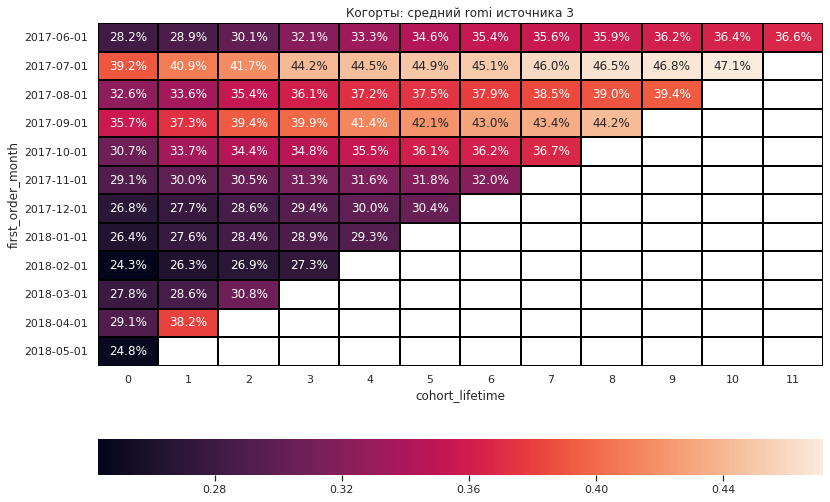

In [123]:
romi_source_cohorts(3)

Третий источник показывает свою полную неэффективность в сравнении с первыми двумя источниками. Ни одна когорта за 12 месяцев не окупилась

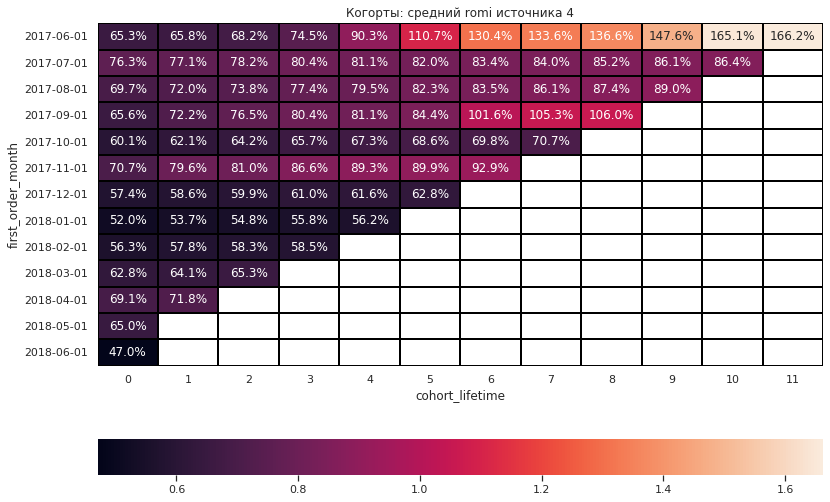

In [124]:
romi_source_cohorts(4)

В источнике 4 окупились июньская и сентябрьская когорты. Первая на - 6 месяц, вторая - на седьмой. По остальным когортам даже если прирост в окупаемости есть, он крайне мал.

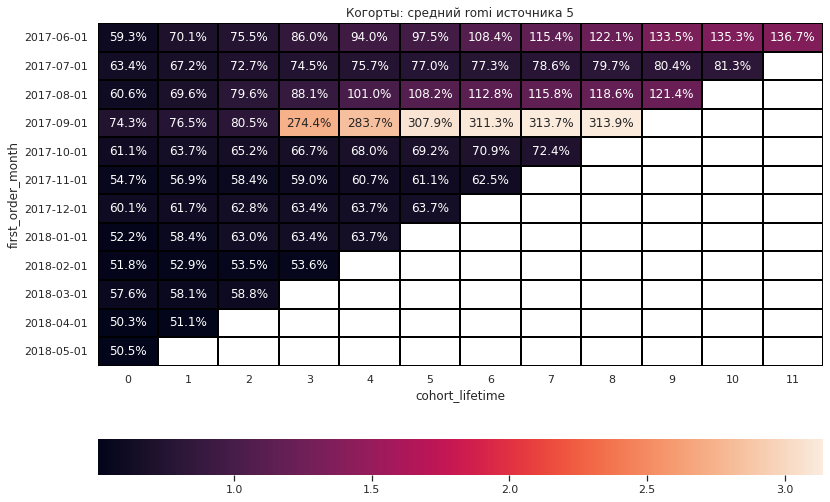

In [125]:
romi_source_cohorts(5)

Здесь мы видим, что достигнута окупаемость 3 когорт: июньской на 7 месяц, августовской на 5 месяц и сентябрьской на 4 месяц. 

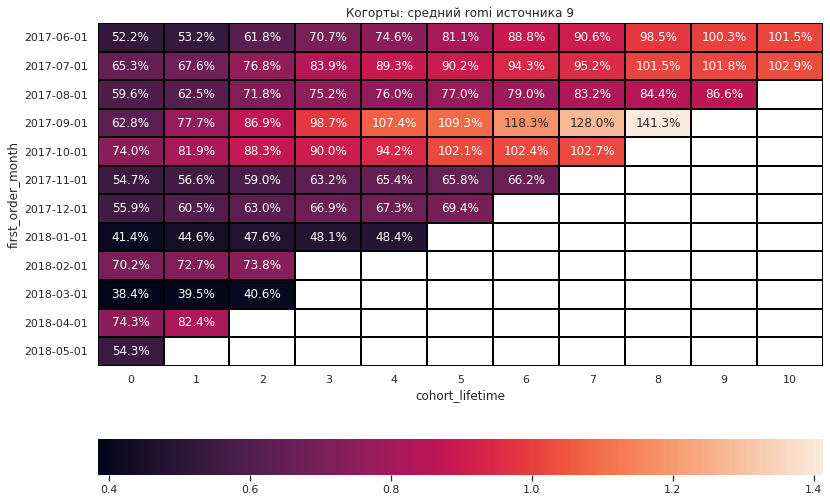

In [126]:
romi_source_cohorts(9)

По источнику девять на окупаемость вышли июньская когорта на 11 месяц, июльская на 10 месяц, сентябрьская на 5 месяц, октябрьская на 6 месяц

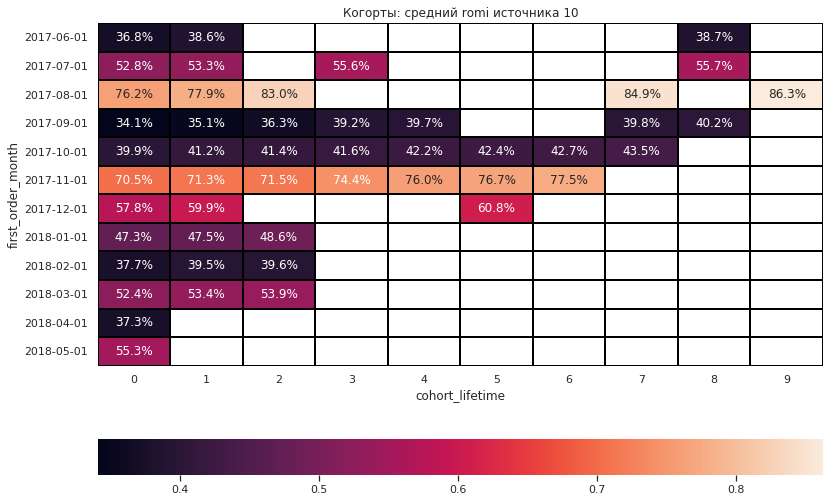

In [127]:
romi_source_cohorts(10)

По источнику 10 ни одна когорта не вышла на окупаемость спустя 12 месяцев.

##### Наиболее перспективнымы источниками привлечение можем считать в порядке убывания источники 1, 9, 5. Источники 4 и 2 по некоторым когортам выходят на окупаемость. 
##### 3 и 10 можем отбросить как неэффективные.  
##### И так же стоит сказать, что по всем источникам окупаемость снижается в более поздних когортах, а прирост окупаемости по месяцам становится и вовсе незначительным. 
##### Первый источник показывает себя лучше всех, так как половина когорт уже вышли на окупаемость. 9 источник тоже показывает неплохие результаты по окупаемости, но за 12 месяцев прибыли мы видим не так много. Получается, что нужно развивать источник 1 и присмотреться к источникам 9 и 5 для улучшения эффективности этих источников.

# Сформулируем выводы и рекомендации

##### 1. В обосновании выбора источника трафика будем основываться на romi в когортах по источникам, cac по источникам и распределение затрат по источникам. Третий и десятый источники оказались самыми неэффективными. А третий источник является одним из самых дорогих по привлечению пользователей и использовал почти половину из всех затрат на маркетинг - больше любого из остальных. 
##### Лучшим источником безоговорочно становится первый, так как половина когорт уже успели окупиться. Стоимость привлечения одного клиента 8 -12. Стоит также присмотреться к источнику 9, так как многие когорты этого источника окупились, а затраты среди всех источников трафика имеет самые низкие, а стоимость привлечения одного клиента либо ниже других, либо на уровне других источников в разные периоды и составляет от 5 до 10. И на третьем месте по эффективности источников стоит - пятый. Часть когорт окупилась, а стоимость привлечения одного клиента стоит 6 - 10. 

##### 2. DAU - 300 - 1000 визитов с июня 2017 по сентябрь 2017. Рост в начале октября и колеблется в районе 700 - 1500. Есть резкий скачок в декабре до 3000. В апреле и мае снижение визитов до уровня 500 - 1000
##### WAU. Увидели изменение визитов в промежутке от 2000 до 10000. С 22 недели по 37 неделю 2017 года количество визитов находится в промежутке между 2000 и 4200. Далее начинается рост и устанавливается стабильный рост-падение визитов, начиная с 40 недели 2017 по 11 неделю 2018 года, в промежутке 6000-8000 визитов. А в 46-47 недели виден скачок визитов до 10000.
##### MAU. Есть рост, начиная с августа 2017 до декабря 2017. И постепенное падение после. Возможно, после лета люди планируют походы в разные места. Потому что если брать концерты и постановки, то, чтобы на них попасть, брать нужно заранее из-за возможной экономии и доступности билетов. Видимо, есть сезонность в активности пользователей. 
##### Средняя пользовательская сессия длится 643 секунды, хотя самое распространённое значение  - 60 секунд.


##### 3. Во всех когортах Retention rate резко падает на второй месяц использования до 5 - 8.5 процентов от первоначального количества пользователей. Более высокими показателями обладают когорты следующих месяцев: июнь, август, сентябрь, октябрь, ноябрь 2017 года. Средний retention rate на второй месяц составляет 6,5 процентов

##### 4. От первого визита до покупки проходит от 4 минут до 3000 минут (5 часов). Выбросы начинаются с 7000 минут. Медиана находится на уровне 16 минут.

##### 5. В большинстве когорт количество покупок варьируется промежутке 1.5 - 2.0. Но выбивается первая когорта с пиковыми значениями в сентябре (4.2) и декабре (4.5). Также есть тренд повышения покупок в декабре в первым четырёх когортах, что может быть связано с покупкой подарков. Самой лояльной остаётся первая когорта.

##### 6. Все когорты на первом месяце "жизни" имеют чек не выше 4 - 5. У большиства когорт средний чек на всём времени жизни находится в пределах 4 - 8. Только у сетрябрьской и декабрьской когорт значения выгодно отличаются. Сентрябрьская когорта имеет чек в промежутке 8 - 17, а в декабре и вовсе имеет пиковое значение в 63. Декабрьская когорта, начиная с 3 месяца жизни, имеет высокий средний чек в промежутке 14 - 26.

##### 7. По LTV выделили три когорты: июньскую, сентябрьскую и декабрьскую. Июньская имеет достаточно линейный рост ltv, поэтому можно ожидать от этой когорты активности и в дальнейшем. Сентябрьская когорта резко возрастает в декабре по рассматриваемому параметру с 7 до 11 и к седьмому месяцу имеет ltv,  сравнимый с первой когортой на 12 месяц. Июльская, августовская и декабрьская когорты растут быстрее, чем оставшиеся.  Декабрьская имеет ltv на шестой месяц выше, чем первая когорта.

##### 8.По затратам источники трафика расположились в таком порядке 3, 4, 5, 2, 1, 10, 9 соответственно. А источник 3 использовал почти половину всех ресурсов. 

##### 9.Самыми дорогими оказались источники 2 и 3. Источник три колеблется в промежутке 13 -20, а источник 2  - в промежутке 13 - 19. Можем отметить рост стоимости привлечения  в определённые месяцы для большиснтва когорт: источники 1-4 растут в цене с июня по август, в ноябре подешевел только источник 4, а остальные подорожали, в январе видим рост стоимости всех источников. В сентябре и декабре видим снижение стоимости почти всех платформ. Можем предположить, что в эти месяцы реклама не так важна и покупатели сами стремятся за билетами на ресурс, чтобы заполучить подарок для себя или других. В точках повышения стоимости возможно снижение проактивности покупателей.

##### 10. ROMI: Мы выбрали источники 1, 9 и 5 для дальнейшего улучшения, так как они доказали значительную окупаемость, и источники 1 и 9 имеют невысокие затраты. Также не безнадёжны источники 4 и 2, так как в некоторых когортах тоже окупаемы. Источники 3 и 10 вовсе неээфективны 

##### 11. Перспективные когорты. В порядке убывания можно расположить перспективные когорты так: сентябрьская, декабрьская, июньская, августовская, июльская 2017 года. Июньская когорта на протяжении 12 месяцев остаётся активной и приносит прибыль уже после выхода на окупаемость, но в дальнейшем рост прибыли будет скорее всего не такой значительный как у декабрьской и сентябрьской. Декабрьская когорта будет иметь по крайней мере ещё 6 месяцев жизни и сможет принести сопоставимую прибыль с июньской когортой. Декабрьская же когорта за 9 месяцев жизни принесла прибыли больше, чем любая другая когорта и есть вероятность, что эта когорта больше других активизируется в праздничные дни, что может вести к взрывной прибыли. Когорты авкуста и июля уже вышли на окупаемость, но несут не такую большую прибыль как уже описанные. 